# Ungraded Lab: Training a Deep Neural Network with Time Series Data

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week2/Labs/C4_W2_Lab_3_deep_NN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will build upon the previous exercise and add more dense layers to your network. You will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so you can avoid guessing the learning rate before training.

The initial steps will be identical to the previous lab so you can run the next cells until the `Build the Model` section. That's where the discussions begin.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential, Input, layers, optimizers, metrics, callbacks

2024-06-13 20:18:29.145252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    sns.set_style("whitegrid")

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)
    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

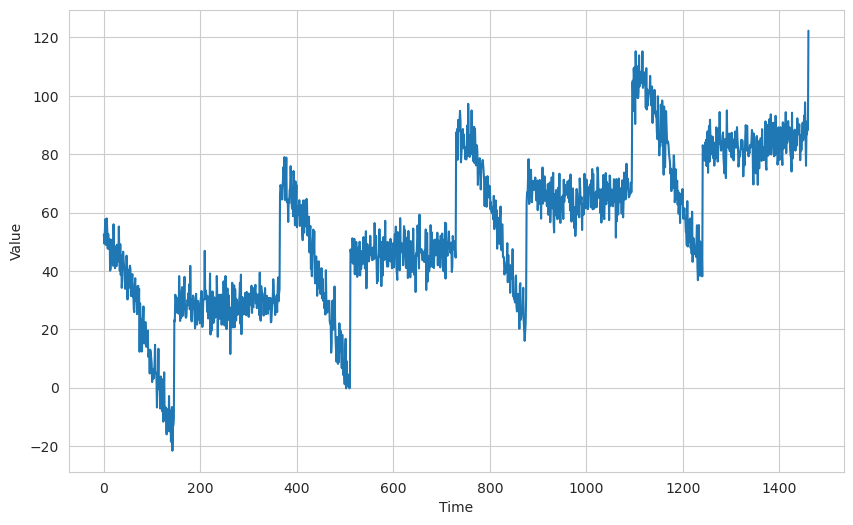

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-13 20:18:31.495700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1723 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Build the Model

You will use three dense layers in this exercise as shown below. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [8]:
# Build the model
model_baseline = Sequential([Input(shape=(window_size,)),
                             layers.Dense(10, activation="relu"),
                             layers.Dense(10, activation="relu"),
                             layers.Dense(1)])

# Print the model summary
model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

You will then compile and train the model using the same settings as before. Observe how the loss is decreasing because you will revisit it later in this lab.

In [9]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [10]:
# Train the model
model_baseline.fit(dataset, epochs=100)

Epoch 1/100


I0000 00:00:1718331512.013393  476291 service.cc:145] XLA service 0x7fcbe4003940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718331512.013417  476291 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-13 20:18:32.024551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 20:18:32.066721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


      1/Unknown 1s 855ms/step - loss: 3091.1909

I0000 00:00:1718331512.488755  476291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1160.8525
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 81.6303
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 63.4364
Epoch 4/100


2024-06-13 20:18:32.917185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:32.917215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:32.917231: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:32.917239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your datas

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 55.3590
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 52.5897
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 58.0918
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 56.9618
Epoch 8/100


2024-06-13 20:18:33.160533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.160557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:33.160565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:33.160572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:33.225654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.225678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 59.7756
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 53.7132
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 64.0527
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 67.5716
Epoch 12/100


2024-06-13 20:18:33.418741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.418765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:33.418773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:33.418780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:33.482403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.482430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 60.1587
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 59.8562
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 58.4334
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 61.7649
Epoch 16/100


2024-06-13 20:18:33.678194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.678217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:33.678225: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:33.678232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:33.741151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.741176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 55.1956
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 44.0081
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 56.2757
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 47.0091


2024-06-13 20:18:33.942405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:33.942428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:33.942436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:33.942443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:34.009312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.009334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 52.1453
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 48.6749
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 58.8319
Epoch 23/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 25.9166

2024-06-13 20:18:34.209986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.210013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:34.210024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:34.210034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:34.276963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.276987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 43.0997
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 55.5221
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 48.5599
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 50.8634
Epoch 27/100


2024-06-13 20:18:34.474724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.474749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:34.474757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:34.474764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:34.588235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.588265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 48.9197
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 46.0382
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 53.3551
Epoch 30/100


2024-06-13 20:18:34.736108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.736135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:34.736143: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:34.736150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:34.810636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.810670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 45.7048
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 43.7877
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 47.8215
Epoch 33/100


2024-06-13 20:18:34.989477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:34.989505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:34.989516: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:34.989524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:35.066701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.066727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 49.2490
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 47.5820
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 44.8918
Epoch 36/100


2024-06-13 20:18:35.216234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.216261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:35.216271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:35.216278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:35.292089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.292112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.7273 
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 48.3971
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 44.3193
Epoch 39/100


2024-06-13 20:18:35.451515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.451552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:35.451566: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:35.451577: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:35.530947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.530972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50.9589 
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 44.4115
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 43.3559
Epoch 42/100


2024-06-13 20:18:35.694704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.694747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:35.694765: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:35.694781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:35.796090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.796114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 48.4432
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 50.5168
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 44.0218
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 49.2586
Epoch 46/100


2024-06-13 20:18:35.927409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.927434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:35.927442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:35.927448: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:35.991288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:35.991311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.7784 
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 47.6647
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 45.5788
Epoch 49/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 41.0806

2024-06-13 20:18:36.207343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.207397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:36.207412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:36.207426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:36.278018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.278045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 46.4526
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 47.8199
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 50.1736
Epoch 52/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 43.7009

2024-06-13 20:18:36.416421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.416446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:36.416455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:36.416462: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:36.480339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.480364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 43.9787
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 42.1396
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 53.6634
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 46.5217
Epoch 56/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 26.8146

2024-06-13 20:18:36.683715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.683741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:36.683749: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:36.683755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:36.748742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.748779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 40.1826
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 47.0360
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 43.5314
Epoch 59/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 56.8437

2024-06-13 20:18:36.892737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.892764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:36.892773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:36.892780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:36.968197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:36.968223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 45.5348
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 38.7790
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 43.6643
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 46.2169
Epoch 63/100


2024-06-13 20:18:37.096351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.096377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:37.096385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:37.096391: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:37.160442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.160467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 45.2528
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 49.0536
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 43.2309
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 46.2157
Epoch 67/100


2024-06-13 20:18:37.355176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.355201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:37.355209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:37.355217: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:37.418848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.418871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 48.2277
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.4162 
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 47.2205
Epoch 70/100


2024-06-13 20:18:37.618350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.618375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:37.618385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:37.618394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:37.712599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.712622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 45.2900
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 43.4279
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 43.3948
Epoch 73/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 47.1425

2024-06-13 20:18:37.864162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.864189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:37.864197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:37.864204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:37.931951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:37.931980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 43.4287
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 41.5689
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 44.7286
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 42.8151
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 40.6415
Epoch 78/100


2024-06-13 20:18:38.128693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.128717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:38.128726: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:38.128732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:38.193471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.193494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 46.5954
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 41.8368
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 44.9072
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 54.1706
Epoch 82/100


2024-06-13 20:18:38.392792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.392819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:38.392830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:38.392841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:38.457282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.457305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 41.4521
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 49.9409
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 48.3195
Epoch 85/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 18.1780

2024-06-13 20:18:38.656089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.656113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:38.656121: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:38.656128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:38.724715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.724740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 40.1624
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 47.0848
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 42.0574
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 40.9462
Epoch 89/100


2024-06-13 20:18:38.925555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.925579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:38.925587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:38.925595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:38.991917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:38.991941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 50.1477
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 46.2592
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 39.0265
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 44.4035
Epoch 93/100


2024-06-13 20:18:39.170147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:39.170171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:39.170180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:39.170187: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:39.234781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:39.234807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 48.6638
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 37.5641
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 41.2665
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 41.6560
Epoch 97/100


2024-06-13 20:18:39.430342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:39.430365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:39.430376: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:39.430385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:39.494457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:39.494481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 49.9744
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 40.6464
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 46.7133
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 38.9322


2024-06-13 20:18:39.690770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:39.690801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:18:39.690814: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:18:39.690824: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:18:39.754855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:18:39.754880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

You can then get some predictions and visualize it as before. Since the network is deeper, the predictions might go slower so you may want to minimize unnecessary computations.

In the previous lab, you might remember the model generating predictions using the entire `series` data. That resulted in 1,441 points in the `forecast` list then you sliced the 461 points that aligns with the validation set using `forecast = forecast[split_time - window_size:]`.

You can make this process faster by just generating 461 points right from the start. That way, you don't waste time predicting points that will just be thrown away later. The code below will do just that. It will just get the points needed from the original `series` before calling the `predict()` method. With that, all predictions will align with the validation set already and the for-loop will run for only 461 times instead of 1,441.

In the next lab, you'll see an even faster way to generate these predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

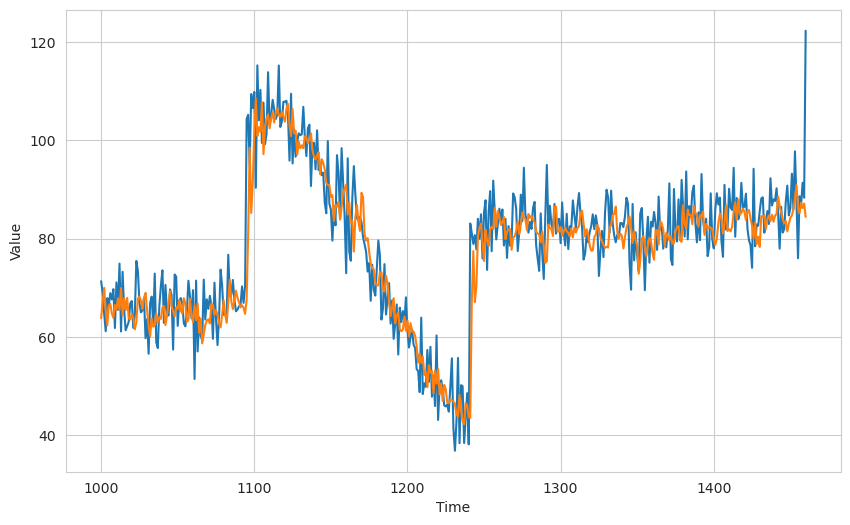

In [11]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then get the MSE and MAE for reference.

In [12]:
# Compute the metrics
print(metrics.mean_squared_error(x_valid, results).numpy())
print(metrics.mean_absolute_error(x_valid, results).numpy())

45.176502
4.93168


## Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [13]:
# Build the Model
model_tune = Sequential([Input(shape=(window_size,)),
                         layers.Dense(10, activation="relu"),
                         layers.Dense(10, activation="relu"),
                         layers.Dense(1)])

Next, you will declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow you to dynamically set the learning rate based on the epoch number during training. As shown below, you will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [14]:
# Set the learning rate scheduler
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

You will then compile the model. Just to note a subtle difference with the lecture video, you don't have to set the `learning_rate` argument of the optimizer here before compiling. You can just leave the default (i.e. [`0.01` for SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) and allow the learning rate scheduler to set it dynamically.

In [15]:
# Initialize the optimizer
optimizer = optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

You will pass in the `lr_schedule` callback in the `callbacks` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. As you run the training below, you will see the learning rate at a particular epoch denoted by `lr` in the console output. Notice that it is increasing as expected based on the lambda function you used.

In [16]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6046.7437 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 3392.3843 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 1692.2336 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 817.5036 - learning_rate: 1.4125e-08
Epoch 5/100


2024-06-13 20:19:00.812828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:00.812901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:00.812918: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:00.812930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:00.877644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:00.877669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 378.9765 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 173.4552 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 162.7039 - learning_rate: 1.9953e-08
Epoch 8/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 259.1707

2024-06-13 20:19:01.080932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:19:01.080957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.080970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:01.148403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.148431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:01.148440: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 146.4636 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 129.3106 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 151.9662 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 160.9132 - learning_rate: 3.1623e-08
Epoch 12/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 75.6280

2024-06-13 20:19:01.347413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.347445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:01.347457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:01.347467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:01.413647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.413669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 131.5698 - learning_rate: 3.5481e-08
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 137.0786 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 144.8048 - learning_rate: 4.4668e-08
Epoch 15/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 204.7783

2024-06-13 20:19:01.558807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.558834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:01.558845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:01.558855: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:01.623110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.623141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 154.9578 - learning_rate: 5.0119e-08
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 137.2323 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 163.6931 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 154.9632 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 136.8745 - learning_rate: 7.9433e-08


2024-06-13 20:19:01.832502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.832527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:01.832535: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:01.832542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:01.898280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:01.898306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 142.4468 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 134.0742 - learning_rate: 1.0000e-07
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 114.7318 - learning_rate: 1.1220e-07
Epoch 23/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 147.1201

2024-06-13 20:19:02.096857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.096879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:02.096888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:02.096895: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:02.163664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.163687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 127.4035 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 132.0164 - learning_rate: 1.4125e-07
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 116.0039 - learning_rate: 1.5849e-07
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 116.6035 - learning_rate: 1.7783e-07
Epoch 27/100


2024-06-13 20:19:02.302930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.302957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:02.302965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:02.302973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:02.366710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.366731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 119.4923 - learning_rate: 1.9953e-07
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 98.6658 - learning_rate: 2.2387e-07
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 122.0910 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 124.6382 - learning_rate: 2.8184e-07
Epoch 31/100


2024-06-13 20:19:02.567215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.567238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:02.567246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:02.567254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:02.633040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.633068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 114.6406 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 94.4022 - learning_rate: 3.5481e-07
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 100.2527 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 99.0959 - learning_rate: 4.4668e-07
Epoch 35/100


2024-06-13 20:19:02.826104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.826129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:02.826138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:02.826145: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:02.892477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:02.892502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 101.8851 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 101.6468 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 103.9260 - learning_rate: 6.3096e-07
Epoch 38/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 27.4662

2024-06-13 20:19:03.088597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.088619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:19:03.088633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:03.163727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.163763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:03.163775: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 79.6401 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 75.6684 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 79.9603 - learning_rate: 8.9125e-07
Epoch 41/100


2024-06-13 20:19:03.296504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.296529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:03.296537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:03.296544: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:03.394185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.394210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 76.3244 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 72.8755 - learning_rate: 1.1220e-06
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 76.5230 - learning_rate: 1.2589e-06
Epoch 44/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 85.3010

2024-06-13 20:19:03.526324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.526346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:03.526355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:03.526361: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:03.598612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.598638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 68.8524 - learning_rate: 1.4125e-06
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 67.5385 - learning_rate: 1.5849e-06
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 69.0360 - learning_rate: 1.7783e-06
Epoch 47/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 47.6760

2024-06-13 20:19:03.737579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.737603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:03.737611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:03.737618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:03.803691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.803716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.7188 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.7805 - learning_rate: 2.2387e-06
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 60.9643 - learning_rate: 2.5119e-06
Epoch 50/100


2024-06-13 20:19:03.953827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:03.953860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:03.953871: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:03.953880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:04.079931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.079965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 58.0007 - learning_rate: 2.8184e-06
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 56.3776 - learning_rate: 3.1623e-06
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 64.5606 - learning_rate: 3.5481e-06
Epoch 53/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 58.6155

2024-06-13 20:19:04.223250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.223273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:04.223281: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:04.223288: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:04.292123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.292151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 57.6488 - learning_rate: 3.9811e-06
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 54.8753 - learning_rate: 4.4668e-06
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 54.2209 - learning_rate: 5.0119e-06
Epoch 56/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 45.9829

2024-06-13 20:19:04.439577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.439602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:04.439610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:04.439618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:04.512959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.512983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 51.4141 - learning_rate: 5.6234e-06
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 69.2467 - learning_rate: 6.3096e-06
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 61.7369 - learning_rate: 7.0795e-06
Epoch 59/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 56.0987

2024-06-13 20:19:04.656991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.657016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:04.657026: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:04.657033: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:04.732728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.732754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.5325 - learning_rate: 7.9433e-06
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 82.6616 - learning_rate: 8.9125e-06
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 59.5263 - learning_rate: 1.0000e-05
Epoch 62/100


2024-06-13 20:19:04.896362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.896386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:04.896395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:04.896403: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:04.976546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:04.976572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 47.4822 - learning_rate: 1.1220e-05
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 54.2179 - learning_rate: 1.2589e-05
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 48.9900 - learning_rate: 1.4125e-05
Epoch 65/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 31.0123

2024-06-13 20:19:05.136869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.136892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:05.136900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:05.136907: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:05.210658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.210687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 49.7440 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 86.8012 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 66.3212 - learning_rate: 1.9953e-05
Epoch 68/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 79.4291

2024-06-13 20:19:05.355380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.355406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:05.355416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:05.355427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:05.431910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.431937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 52.1827 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 71.5868 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 75.1053 - learning_rate: 2.8184e-05
Epoch 71/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 25.2125

2024-06-13 20:19:05.576875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.576899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:05.576907: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:05.576914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:05.649757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.649784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 56.1173 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 55.3320 - learning_rate: 3.5481e-05
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 51.0970 - learning_rate: 3.9811e-05
Epoch 74/100


2024-06-13 20:19:05.788797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.788821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:05.788829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:05.788836: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:05.899939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:05.899969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 47.7852 - learning_rate: 4.4668e-05
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 82.0447 - learning_rate: 5.0119e-05
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 58.3082 - learning_rate: 5.6234e-05
Epoch 77/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 116.6111

2024-06-13 20:19:06.055533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.055563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:06.055572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:06.055580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:06.126005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.126029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 111.5462 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1116.3590 - learning_rate: 7.0795e-05
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 2192.7046 - learning_rate: 7.9433e-05
Epoch 80/100


2024-06-13 20:19:06.267345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.267372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:06.267381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:06.267389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:06.344321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.344346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1909.5121 - learning_rate: 8.9125e-05
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1320.7333 - learning_rate: 1.0000e-04
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1281.8059 - learning_rate: 1.1220e-04
Epoch 83/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 338.0849

2024-06-13 20:19:06.495477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.495503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:06.495512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:06.495519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:06.565074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.565106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 416.5863 - learning_rate: 1.2589e-04
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 371.9058 - learning_rate: 1.4125e-04
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 397.4878 - learning_rate: 1.5849e-04
Epoch 86/100


2024-06-13 20:19:06.709354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.709380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:06.709389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:06.709396: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:06.825580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.825605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 389.5281 - learning_rate: 1.7783e-04
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 401.7369 - learning_rate: 1.9953e-04
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 375.4174 - learning_rate: 2.2387e-04
Epoch 89/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 417.4774

2024-06-13 20:19:06.971940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:06.971969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:06.971978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:06.971986: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:07.047422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.047450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 369.9243 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 391.3304 - learning_rate: 2.8184e-04
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 374.0045 - learning_rate: 3.1623e-04
Epoch 92/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 412.9940

2024-06-13 20:19:07.192605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.192631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:07.192642: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:07.192651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:07.265227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.265253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 376.5342 - learning_rate: 3.5481e-04
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 402.3419 - learning_rate: 3.9811e-04
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 393.9759 - learning_rate: 4.4668e-04
Epoch 95/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 293.2305

2024-06-13 20:19:07.410609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.410634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:07.410642: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:07.410648: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:07.481582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.481609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 394.3062 - learning_rate: 5.0119e-04
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 398.2877 - learning_rate: 5.6234e-04
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 379.9669 - learning_rate: 6.3096e-04
Epoch 98/100


2024-06-13 20:19:07.628771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.628796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:07.628804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:07.628811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:07.742374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.742400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 400.9105 - learning_rate: 7.0795e-04
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 422.0239 - learning_rate: 7.9433e-04
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 379.4192 - learning_rate: 8.9125e-04


2024-06-13 20:19:07.895604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.895627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:07.895636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:07.895643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:07.965171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:07.965204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

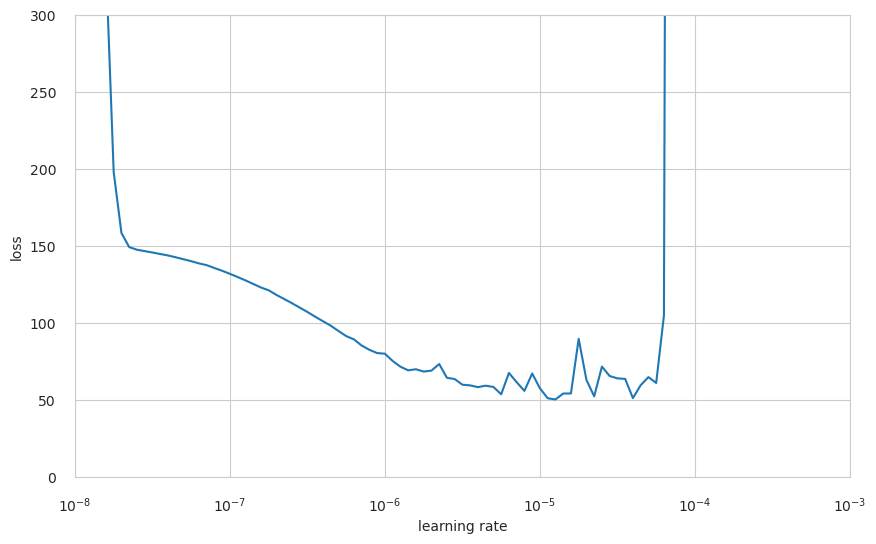

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.

First, you will initialize the same model architecture again.

In [18]:
# Build the model
model_tune = Sequential([Input(shape=(window_size,)),
                         layers.Dense(10, activation="relu"),
                         layers.Dense(10, activation="relu"),
                         layers.Dense(1)])

You will then set the optimizer with a learning rate close to the minimum. It is set to `4e-6` initially but feel free to change based on your results.

In [19]:
# Set the optimizer with the tuned learning rate
optimizer = optimizers.SGD(learning_rate=4e-6, momentum=0.9)

You can then compile and train the model as before. Observe the loss values and compare it to the output of the baseline model you had before. Most likely, you will have met the final loss value of the `model_baseline` within the first 50 epochs of training this `model_tune`. You will also likely have a lower loss after all 100 epochs are done.

In [20]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3644.2424
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 110.6947
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 80.2962
Epoch 4/100


2024-06-13 20:19:09.055368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.055417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:09.055428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:09.055435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:09.120509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.120533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 78.7916
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 65.1734
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 65.0283
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 67.9598
Epoch 8/100


2024-06-13 20:19:09.286796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.286820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:09.286827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:09.286834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:09.350842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.350868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 62.1393
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 63.3677
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 57.4184
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 65.9786
Epoch 12/100


2024-06-13 20:19:09.540499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.540525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:09.540533: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:09.540540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:09.604341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.604365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 58.3805
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 71.1363
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 54.3966
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 54.8990
Epoch 16/100


2024-06-13 20:19:09.795701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.795726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:09.795737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:09.795746: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:09.859738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:09.859763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 61.3493
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 58.4276
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 53.1119
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 59.3655
Epoch 20/100


2024-06-13 20:19:10.060543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.060571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:10.060580: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:10.060588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:10.124526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.124554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 51.1790
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 53.9587
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 56.2789
Epoch 23/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 36.7880

2024-06-13 20:19:10.322396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.322419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:10.322428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:10.322434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:10.391911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.391934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 54.2327
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 45.6032
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.5587 
Epoch 26/100


2024-06-13 20:19:10.589313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.589337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:10.589345: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:10.589352: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:10.672047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.672089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 51.9563
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 51.2185
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 49.2363
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 51.5159
Epoch 30/100


2024-06-13 20:19:10.826560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.826586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:10.826594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:10.826601: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:10.889426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:10.889448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 49.1863
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 58.4769
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 56.8058
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 47.6592
Epoch 34/100


2024-06-13 20:19:11.085719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.085746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:11.085754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:11.085761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:11.150284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.150309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 48.8911
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 49.4091
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 51.9006
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 51.4295
Epoch 38/100


2024-06-13 20:19:11.343970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.343993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:11.344002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:11.344009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:11.407093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.407117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 53.5271
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 54.3706
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 48.1360
Epoch 41/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 117.1564

2024-06-13 20:19:11.601485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.601508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:11.601515: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:11.601522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:11.667145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.667175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 51.9436
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 43.3586
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 45.7393
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 44.7963
Epoch 45/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 50.0892

2024-06-13 20:19:11.871999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.872025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:11.872034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:11.872041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:11.943219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:11.943244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 51.1151
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 46.3193
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.3716 
Epoch 48/100


2024-06-13 20:19:12.086488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.086513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:12.086521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:12.086529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:12.157693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.157719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 46.8381
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 41.6006
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 45.8755
Epoch 51/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 35.0634

2024-06-13 20:19:12.331545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.331574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:12.331584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:12.331592: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:12.404597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.404623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 40.3707
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 43.5177
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 47.5993
Epoch 54/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 66.6849

2024-06-13 20:19:12.550305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.550333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:12.550341: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:12.550349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:12.621007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.621033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 45.7358
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 41.3709
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 39.8691
Epoch 57/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 45.8564

2024-06-13 20:19:12.765838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.765866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:12.765878: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:12.765888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:12.835600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.835626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 47.7193
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 56.3092
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 44.3474
Epoch 60/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 79.2768

2024-06-13 20:19:12.978972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:12.978997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:12.979058: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:12.979067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:13.051681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.051706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 49.7065
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.9566 
Epoch 62/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.6899 

2024-06-13 20:19:13.194039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.194063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:19:13.194078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:13.279401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.279428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:13.279438: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.6747
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 46.9493
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 54.0458
Epoch 65/100


2024-06-13 20:19:13.398582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.398619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:13.398635: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:13.398651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:13.483626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.483654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 39.2530
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 50.6539
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 42.6306
Epoch 68/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 49.8735

2024-06-13 20:19:13.637268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.637294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:13.637303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:13.637311: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:13.711661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.711687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 46.1151
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 54.7712
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 47.4230
Epoch 71/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 34.0316

2024-06-13 20:19:13.856958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.856984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:13.856993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:13.857001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:13.927704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:13.927733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 48.0050
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 46.2603
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 46.4972
Epoch 74/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 86.1377

2024-06-13 20:19:14.071977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.072004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:14.072012: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:14.072020: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:14.142614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.142638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 51.8771
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 47.1909
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 49.0003
Epoch 77/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 29.9883

2024-06-13 20:19:14.284955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.284980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:14.284989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:14.284996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:14.359167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.359195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 52.2963
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 45.5766
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 41.7810
Epoch 80/100


2024-06-13 20:19:14.509116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.509141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:14.509150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:14.509158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:14.585349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.585374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 45.7465
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 45.5076
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 43.1637
Epoch 83/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 20.8121

2024-06-13 20:19:14.736354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.736382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:19:14.736398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:14.809611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.809636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:14.809645: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.3072
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 46.8090
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 52.5201
Epoch 86/100


2024-06-13 20:19:14.993504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:14.993534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:19:14.993550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:15.083588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.083620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:15.083634: I tensorflow/core/framework/local_ren

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 41.0027
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 46.0054
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 43.8253
Epoch 89/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 28.6730

2024-06-13 20:19:15.242378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.242404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:15.242413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:15.242421: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:15.316970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.316997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 38.8113
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 49.5342
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 51.8013
Epoch 92/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 33.7139

2024-06-13 20:19:15.461616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.461642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:15.461651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:15.461660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:15.532977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.533001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 44.4313
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 46.2145
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 38.9974
Epoch 95/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 36.2038

2024-06-13 20:19:15.674298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.674325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:15.674334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:15.674342: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:15.746108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.746134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 39.8221
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 39.8416
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 45.0913
Epoch 98/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 30.6558

2024-06-13 20:19:15.892992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.893019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:15.893028: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:15.893035: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:15.970175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:15.970204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 41.5585
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 44.9494
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 44.3417


2024-06-13 20:19:16.115189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:16.115219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-13 20:19:16.115229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6958387059001690563
2024-06-13 20:19:16.115237: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3127515685164577871
2024-06-13 20:19:16.187950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:19:16.187973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

You can plot the `loss` values by getting it from the [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object returned by the `fit()` method. As you can see, the model is still trending downward after the training.

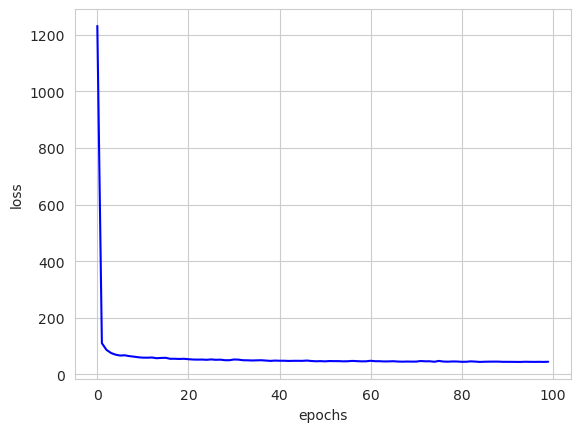

In [21]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

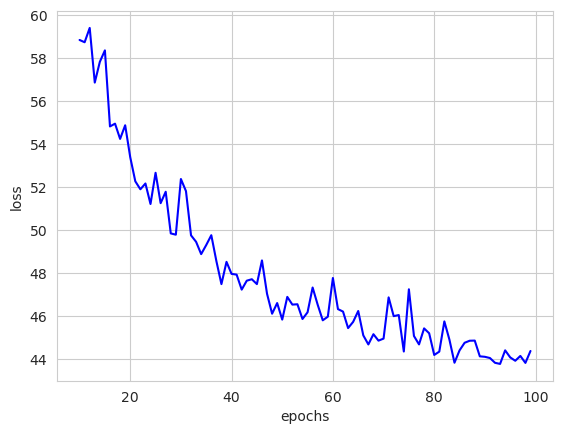

In [22]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]

plt.figure()
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

You can get the predictions again and overlay it on the validation set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

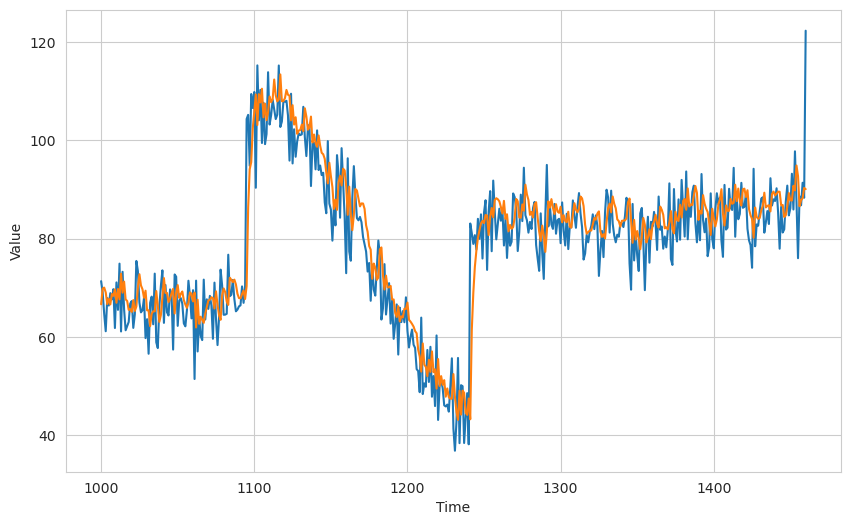

In [23]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Finally, you can compute the metrics and you should arrive at similar figures compared to the baseline. If it is much worse, then the model might have overfitted and you can use techniques you know to avoid it (e.g. adding dropout).

In [24]:
print(metrics.mean_squared_error(x_valid, results).numpy())
print(metrics.mean_absolute_error(x_valid, results).numpy())

47.077557
5.2391047


## Wrap Up

This concludes the exercise on using a deep neural network for forecasting. Along the way, you did some hyperparameter tuning, particularly on the learning rate. You will be using this technique as well in the next labs. Next week, you will be using recurrent neural networks to build your forecasting model. See you there and keep it up!